In [1]:
import pandas
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

Using TensorFlow backend.


In [12]:
input_shape = (32, 32)
categories_num = 37
batch_size = 64

In [4]:
train_data = pandas.read_csv('./train_pets.csv', usecols=['Category', 'Path'])
val_data = pandas.read_csv('./val_pets.csv', usecols=['Category', 'Path'])

train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        batch_size=batch_size)

Found 5984 validated image filenames belonging to 37 classes.
Found 703 validated image filenames belonging to 37 classes.


In [5]:
def plot_history(history, save=False, folder=""):
    # Plot training & validation accuracy values
    plt.figure(1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [6]:
from keras import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.metrics import categorical_accuracy

def fc_model_1(units_num, activation):
    model = Sequential()

    model.add(Flatten(input_shape=(input_shape[0], input_shape[1], 3,)))

    model.add(Dense(units=units_num))
    model.add(Activation(activation))

    model.add(Dense(units=categories_num, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[categorical_accuracy])

    return model

In [13]:
model = fc_model_1(units_num=128, activation='tanh')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               393344    
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 37)                4773      
Total params: 398,117
Trainable params: 398,117
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
 - 35s - loss: 3.7190 - categorical_accuracy: 0.0360 - val_loss: 3.5483 - val_categorical_accuracy: 0.0501
Epoch 2/10
 - 35s - loss: 3.5536 - categorical_accuracy: 0.0558 - val_loss: 3.5369 - val_categorical_accuracy: 0.0501
Epoch 3/10
 - 34s - loss: 3.5047 - categorical_accuracy: 0.0608 - val_loss: 3.4990 - val_categorical_accuracy: 0.0516
Epoch 4/10
 - 33s - loss: 3.4810 - categorical_accuracy: 0.0728 - val_loss: 3.4586 - val_categorical_accuracy: 0.0736
Epoch 5/10
 - 34s - loss: 3.4592 - categorical_accuracy: 0.0706 - val_loss: 3.4251 - val_categorical_accuracy: 0.0720
Epoch 6/10
 - 33s - loss: 3.4410 - categorical_accuracy: 0.0776 - val_loss: 3.4081 - val_categorical_accuracy: 0.0798
Epoch 7/10
 - 34s - loss: 3.4216 - categorical_accuracy: 0.0783 - val_loss: 3.3861 - val_categorical_accuracy: 0.0673
Epoch 8/10
 - 33s - loss: 3.4009 - categorical_accuracy: 0.0833 - val_loss: 3.3665 - val_categorical_accuracy: 0.0657
Epoch 9/10
 - 33s - loss: 3.3883 - categorical_accuracy:

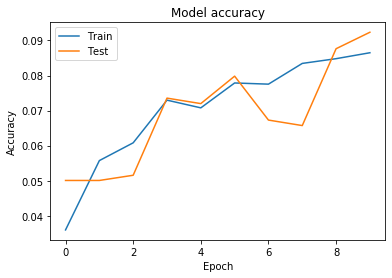

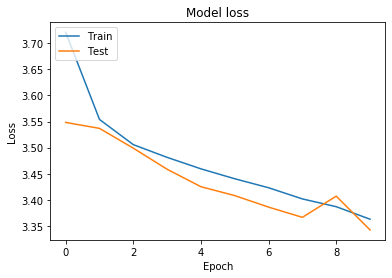

In [14]:
early_stop = EarlyStopping(patience=4)

history = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[early_stop])

plot_history(history)

In [17]:
%%time
for units_num, activation in itertools.product([256, 1024], ['tanh', 'relu', 'selu']):
    print(f'Environment: {units_num} units, {activation} activation')
    
    model = fc_model_1(units_num=units_num, activation=activation)
    
    history = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=20,
            verbose=0,
            callbacks=[early_stop])
    
    model.save(f'./fc_checkpoints/1l-{units_num}u-{activation}.h5')
    
    print(f"  - epochs: {len(history.history['loss'])}"
          f" - test loss: {round(min(history.history['loss']), 4)}"
          f" - val loss: {round(min(history.history['val_loss']), 4)}"
          f" - test acc: {round(max(history.history['categorical_accuracy']), 4)}"
          f" - val acc: {round(max(history.history['val_categorical_accuracy']), 4)}")

Environment: 256 units, tanh activation
  - epochs: 20  - test loss: 3.29  - val loss: 3.2853  - test acc: 0.1017  - val acc: 0.1111
Environment: 256 units, relu activation
  - epochs: 20  - test loss: 3.1947  - val loss: 3.2156  - test acc: 0.1287  - val acc: 0.1236
Environment: 256 units, selu activation
  - epochs: 9  - test loss: 3.4162  - val loss: 3.388  - test acc: 0.0889  - val acc: 0.1017
Environment: 1024 units, tanh activation
  - epochs: 17  - test loss: 4.1531  - val loss: 4.14  - test acc: 0.0794  - val acc: 0.1064
Environment: 1024 units, relu activation
  - epochs: 17  - test loss: 3.1786  - val loss: 3.2312  - test acc: 0.1247  - val acc: 0.1283
Environment: 1024 units, selu activation
  - epochs: 5  - test loss: 15.5103  - val loss: 15.6388  - test acc: 0.0275  - val acc: 0.0297
CPU times: user 53min 50s, sys: 35.4 s, total: 54min 25s
Wall time: 47min 51s


In [22]:
def fc_model_2(units_num, activation):
    model = Sequential()

    model.add(Flatten(input_shape=(input_shape[0], input_shape[1], 3,)))

    model.add(Dense(units=units_num[0]))
    model.add(Activation(activation))
    
    model.add(Dense(units=units_num[1]))
    model.add(Activation(activation))

    model.add(Dense(units=categories_num, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

    return model

In [23]:
model = fc_model_2(units_num=[128, 64], activation='tanh')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               393344    
_________________________________________________________________
activation_13 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_14 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 37)                2405      
Total params: 404,005
Trainable params: 404,005
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
 - 33s - loss: 3.6120 - categorical_accuracy: 0.0368 - val_loss: 3.5227 - val_categorical_accuracy: 0.0454
Epoch 2/10
 - 33s - loss: 3.5024 - categorical_accuracy: 0.0566 - val_loss: 3.4763 - val_categorical_accuracy: 0.0563
Epoch 3/10
 - 33s - loss: 3.4878 - categorical_accuracy: 0.0610 - val_loss: 3.4599 - val_categorical_accuracy: 0.0719
Epoch 4/10
 - 33s - loss: 3.4589 - categorical_accuracy: 0.0610 - val_loss: 3.4456 - val_categorical_accuracy: 0.0673
Epoch 5/10
 - 33s - loss: 3.4443 - categorical_accuracy: 0.0652 - val_loss: 3.4611 - val_categorical_accuracy: 0.0532
Epoch 6/10
 - 32s - loss: 3.4293 - categorical_accuracy: 0.0675 - val_loss: 3.4019 - val_categorical_accuracy: 0.0798
Epoch 7/10
 - 33s - loss: 3.3963 - categorical_accuracy: 0.0790 - val_loss: 3.3629 - val_categorical_accuracy: 0.0955
Epoch 8/10
 - 32s - loss: 3.3938 - categorical_accuracy: 0.0754 - val_loss: 3.3765 - val_categorical_accuracy: 0.0861
Epoch 9/10
 - 34s - loss: 3.3582 - categorical_accuracy:

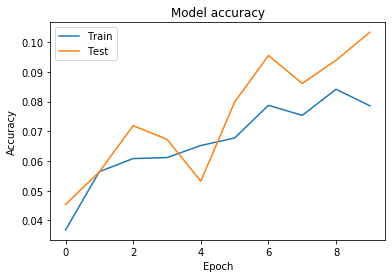

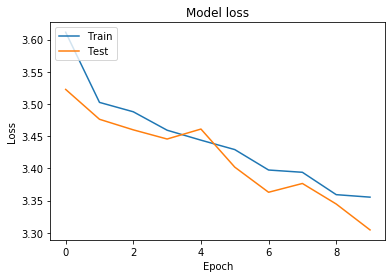

In [24]:
history = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[early_stop])

plot_history(history)

In [26]:
%%time
for units_num, activation in itertools.product([[512, 256], [1024, 512]], ['tanh', 'relu', 'selu']):
    print(f'Environment: {units_num} units, {activation} activation')
    
    model = fc_model_2(units_num=units_num, activation=activation)
    
    history = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=epochs,
            verbose=0,
            callbacks=[early_stop])
    
    model.save(f'./fc_checkpoints/2l-{units_num}u-{activation}.h5')
    
    print(f"  - epochs: {len(history.history['loss'])}"
          f" - test loss: {round(min(history.history['loss']), 4)}"
          f" - val loss: {round(min(history.history['val_loss']), 4)}"
          f" - test acc: {round(max(history.history['categorical_accuracy']), 4)}"
          f" - val acc: {round(max(history.history['val_categorical_accuracy']), 4)}")

Environment: [512, 256] units, tanh activation
  - epochs: 8 - test loss: 3.489 - val loss: 3.4698 - test acc: 0.0603 - val acc: 0.0736
Environment: [512, 256] units, relu activation
  - epochs: 12 - test loss: 3.1767 - val loss: 3.2335 - test acc: 0.1247 - val acc: 0.1142
Environment: [512, 256] units, selu activation
  - epochs: 18 - test loss: 3.2222 - val loss: 3.2489 - test acc: 0.128 - val acc: 0.1315
Environment: [1024, 512] units, tanh activation
  - epochs: 18 - test loss: 3.5232 - val loss: 3.4836 - test acc: 0.0576 - val acc: 0.0766
Environment: [1024, 512] units, relu activation
  - epochs: 11 - test loss: 3.205 - val loss: 3.2077 - test acc: 0.1162 - val acc: 0.1236
Environment: [1024, 512] units, selu activation
  - epochs: 17 - test loss: 3.3004 - val loss: 3.3445 - test acc: 0.1084 - val acc: 0.1174
CPU times: user 52min 34s, sys: 37.6 s, total: 53min 12s
Wall time: 46min 32s


Epoch 1/100
 - 33s - loss: 3.2571 - categorical_accuracy: 0.1183 - val_loss: 3.3372 - val_categorical_accuracy: 0.0908
Epoch 2/100
 - 33s - loss: 3.2621 - categorical_accuracy: 0.1060 - val_loss: 3.4681 - val_categorical_accuracy: 0.0861
Epoch 3/100
 - 33s - loss: 3.3068 - categorical_accuracy: 0.1126 - val_loss: 3.4073 - val_categorical_accuracy: 0.0986
Epoch 4/100
 - 33s - loss: 3.2693 - categorical_accuracy: 0.1159 - val_loss: 3.3696 - val_categorical_accuracy: 0.0814
Epoch 5/100
 - 33s - loss: 3.2564 - categorical_accuracy: 0.1242 - val_loss: 3.3261 - val_categorical_accuracy: 0.1109
Epoch 6/100
 - 33s - loss: 3.2322 - categorical_accuracy: 0.1245 - val_loss: 3.2792 - val_categorical_accuracy: 0.1049
Epoch 7/100
 - 33s - loss: 3.2445 - categorical_accuracy: 0.1190 - val_loss: 3.2644 - val_categorical_accuracy: 0.1283
Epoch 8/100
 - 33s - loss: 3.2211 - categorical_accuracy: 0.1287 - val_loss: 3.4300 - val_categorical_accuracy: 0.0876
Epoch 9/100
 - 33s - loss: 3.2272 - categorical_

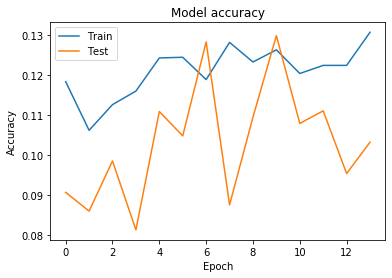

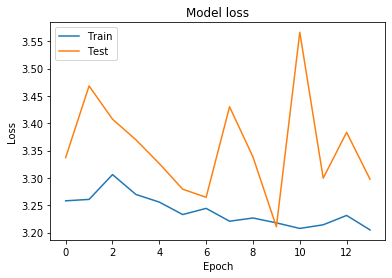

In [28]:
best_model = fc_model_1(units_num=256, activation='relu')

history = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
            callbacks=[early_stop])

model.save(f'./fc_checkpoints/best_model.h5')
plot_history(history)

In [40]:
test_data = pandas.read_csv('./test_pets.csv', usecols=['Category', 'Path'])

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        batch_size=1)

test_model = load_model(f'./fc_checkpoints/best_model.h5')

test_loss = test_model.evaluate_generator(test_generator, steps=100)

print(f'test loss: {test_loss[0]}, test accuracy: {test_loss[1]}')

Found 703 validated image filenames belonging to 37 classes.
test loss: 3.335000809431076, test accuracy: 0.08


In [45]:
sample = test_generator.next()
image_array = sample[0]
categories_dict = {value: key for key, value in test_generator.class_indices.items()}
category = categories_dict[np.argmax(sample[1][0])]

predictions = test_model.predict(image_array)[0]

best_args = np.argsort(predictions)[::-1][:3]

print(f'Original: {category}')
for i in best_args:
    print(categories_dict[i], predictions[i])

import cv2
image = np.empty((input_shape[0], input_shape[1], 3), dtype=np.uint8)
cv2.imshow('image', image)
cv2.waitKey()

Original: Bombay
newfoundland 0.55126566
Bombay 0.2184349
scottish_terrier 0.06754174


32